# Сегментация абонентов_Мегафон

Необходимо подготовить выборку к анализу (выделить/исключить нехарактерные значения) и сделать сегментацию (3-5 сегментов) на основе профиля абонента.
<br>Обоснуйте выбор критериев, сделать выводы и визуализируйте их.
<br>В таблице приведена выборка абонентов и показателей по ним - ежемесячные начисления, трафик, тип устройства.

<b>Данные</b>
* id - ID абонента
* category - Категория устройства
* sum_r - Сумма начислений в месяц, руб
* call_min - Трафик голосовой, мин
* internet_mb - Трафик передачи данных, Мб мегабайт
* mnr_min - Трафик в роуминге, мин

In [281]:
import pandas as pd
import numpy as np
import seaborn as sns

import plotly.express as px
import matplotlib.pyplot as plt

In [282]:
# загружаю датасет
import requests
from urllib.parse import urlencode

base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
public_key = 'https://disk.yandex.ru/d/kL-YKUxUIXEUHA'

# Получаю загрузочную ссылку
final_url = base_url + urlencode(dict(public_key=public_key))
response = requests.get(final_url)
download_url = response.json()['href']

df = pd.read_csv(download_url, sep=';')
df.head()

,id,category,sum_r,call_min,internet_mb,mnr_min
0,4277642,SMARTPHONE,11962,1004,13976,2
1,4277933,SMARTPHONE,13865,1159,3620,23
2,4278138,SMARTPHONE,3905,6301,2298,0
3,4281994,SMARTPHONE,12476,1846,6296,70
4,4282050,SMARTPHONE,9520,6566,2577,2


### Исследование данных и предобработка датасета

<b>Overview EDA:</b>
* Исключены отрицательные значения в колонках 
* Удалены дубли
* Очищены строки с пропущенными значениями в поле category, дублирующие полные строки (строки с пропущенными значениями category, но НЕ дубли сохранены в датасете)
* Проведена оценка полей call_min, internet_mb, mnr_min, исключены строки с трафиком call_min выше оценочного значения
* Проведена оценка значений sum_r (кейсы трафик нулевой - начисления есть, трафик есть - начисления нулевые)

Обоснования представлены дальше по ходу исследования.
<br>Вместе с этим необходимо провести анализ причин появления отрицательных значений, дубликатов, пропущенных и экстремальных значений в датасете. Настроить процедуры проверки.
<br>Выяснить является ли нормой высокие начисления при нулевом трафике и наоборот трафик при нулевых начислениях. 

In [283]:
df.shape

(14636, 6)

In [284]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14636 entries, 0 to 14635
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           14636 non-null  int64 
 1   category     14589 non-null  object
 2   sum_r        14636 non-null  int64 
 3   call_min     14636 non-null  int64 
 4   internet_mb  14636 non-null  int64 
 5   mnr_min      14636 non-null  int64 
dtypes: int64(5), object(1)
memory usage: 686.2+ KB


<i><b>Исключаю отрицательные значения</b></i>
<br>По описательным статистикам обнаруживаю отрицательные значения в полях sum_r, call_min, internet_mb, mnr_min.
<br>Необходимо уточнение природы отрицательных значений (ошибка, перерасчёт/возврат денег, возврат минут и трафика). Так как случай не типичный и не помогает в определении профиля абонента, считаю, что сейчас строки можем исключить.

In [285]:
# описательные статистики полей
df['sum_r'].describe()

count    1.463600e+04
mean     1.012563e+05
std      1.242867e+07
min     -1.003596e+08
25%      3.150000e+02
50%      7.570000e+02
75%      1.758250e+03
max      1.500098e+09
Name: sum_r, dtype: float64

In [286]:
df['call_min'].describe()

count    1.463600e+04
mean     2.241517e+03
std      9.767642e+04
min     -5.410000e+02
25%      4.000000e+00
50%      5.800000e+01
75%      9.800000e+02
max      8.335668e+06
Name: call_min, dtype: float64

In [287]:
df['internet_mb'].describe()

count    1.463600e+04
mean     2.353134e+04
std      4.820615e+04
min     -5.193700e+04
25%      4.737500e+02
50%      3.052500e+03
75%      4.371575e+04
max      1.772188e+06
Name: internet_mb, dtype: float64

In [288]:
df['mnr_min'].describe()

count    14636.000000
mean        93.169650
std        308.743696
min         -1.000000
25%          0.000000
50%          0.000000
75%          0.000000
max       6783.000000
Name: mnr_min, dtype: float64

In [289]:
df = df.query("sum_r >= 0 and call_min >= 0 and internet_mb >= 0 and mnr_min >= 0")
df.shape

(14595, 6)

<i><b>Удаляю дубли</b></i>
<br>По результатам проверки на дубликаты найдены повторяющиеся строки, определяю их как дубли скорее всего в результате технической ошибки, но этот момент требует уточнений и проверки.
<br>Очищаю таблицу от дублей.

In [290]:
# проверка на дубликаты
df.loc[df.duplicated()]

,id,category,sum_r,call_min,internet_mb,mnr_min
180,5658881,PHONE,19246,7588,1,3
365,9434483,SMARTPHONE,11319,6444,38808,2
488,13247179,SMARTPHONE,11407,7094,21429,196
757,25219789,PHONE,20585,7797,0,471
931,32791580,SMARTPHONE,11379,2512,2000,747
1429,126955670,SMARTPHONE,15152,6785,5143,5703
3482,141665810,SMARTPHONE,442070,248652,0,0
3544,141967467,SMARTPHONE,15209,1657,16463,1004
5268,147432392,SMARTPHONE,14434,2112,59246,1030
5478,147925809,PHONE,16667,10520,0,0


In [291]:
df[df.id == 5658881]

,id,category,sum_r,call_min,internet_mb,mnr_min
179,5658881,PHONE,19246,7588,1,3
180,5658881,PHONE,19246,7588,1,3


In [292]:
# удаляю дубли
df = df.drop_duplicates()
df.shape

(14569, 6)

<i><b>Проверяю пропущенные значения</b></i>
<br>Обнаружены пустые значения в столбце category. Я решила пробить все id с путыми category и посмотреть на весь получившийся dataframe.
<br>Изначально, показалось, что NaN-строки - это дубли полных строк (например строка с id=133824953), но если посмотреть на id 141817732, то здесь подключение произведено с нескольких устройств и суммы разные. Значит могли быть подключения с неопознанных устройств (или не определённых по техническим ошибкам).
<br>Уберём в парах строки с одинаковыми id и суммами, где category пусто.

In [293]:
# проверка на пропущенные значения
df.isna().sum()

id              0
category       47
sum_r           0
call_min        0
internet_mb     0
mnr_min         0
dtype: int64

In [294]:
# готовлю список id с незаполненной category 
id_nan = df[df['category'].isna()].id

In [295]:
# строки с id, где не заполнена category
df_cat_nan = df.query('id in @id_nan')
df_cat_nan

,id,category,sum_r,call_min,internet_mb,mnr_min
200,5826044,NaN,12803,2092,66754,22
1998,130637642,NaN,1253,6165,18216,0
2286,133140518,NaN,2629,9815,0,1110
2354,133824953,SMARTPHONE,15386807,8335668,0,0
2355,133824953,NaN,15386807,8335668,0,0
2461,134523609,NaN,162,56,4582,0
3226,139850186,NaN,261,7254,376,0
3310,140382627,NaN,1510,6304,0,4
3313,140389654,NaN,1520,6066,0,6
3514,141817732,SMARTPHONE,738,1,2450,0


In [296]:
# отбираю id, где дублируются все колонки кроме category
df_cat_nan.loc[df_cat_nan.duplicated(subset=['id', 'sum_r', 'call_min', 'internet_mb', 'mnr_min'])]

,id,category,sum_r,call_min,internet_mb,mnr_min
2355,133824953,NaN,15386807,8335668,0,0
4925,146499364,NaN,28033,37160,0,0
9523,398225597,NaN,19163,7789,0,0
12723,437453958,NaN,14109,8590,0,0
13532,444826720,NaN,47350,27546,0,0


In [297]:
# список индексов строк на удаление
nan_dupl = df_cat_nan.loc[df_cat_nan.duplicated(subset=['id', 'sum_r', 'call_min', 'internet_mb', 'mnr_min'])].id.index
nan_dupl

Int64Index([2355, 4925, 9523, 12723, 13532], dtype='int64')

In [298]:
# оставляю нужные строки
df = df.reset_index().query('index not in @nan_dupl')
df.shape

(14564, 7)

<b><i> Оцениваю поля call_min, internet_mb, mnr_min</b></i>

В описательных статистиках колонок встречаются высокие значения в полях call_min, internet_mb, mnr_min.
<br>Посчитаем сколько в месяц можно наговорить минут.

In [299]:
print(f'{30*24*60} минут в месяц')

43200 минут в месяц


Получается строки с трафиком свыше 43 200 минут либо ошибочные, т.к. невозможно наговорить больше минут, чем есть в сутках, либо например многоканальные.
<br>Здесь есть веский повод доуточниться в данных, которые мы оцениваем - это абоненты физ.лица или юр.лица тоже. В первом случае, если сегментируем физ.лиц, строки свыше 43 200 минут нужно исключить +порог можно было бы ещё снизить, например исключив время сна, т.е. 30 * 6 * 60 = 10 800 минут. Во втором случае, если в выборке действительно есть физ.лица и юр.лица, разделить абонентов на сегменты по виду юр.лиц, подтянуть справочник с инн.
<br>Так как анализ выполняется для B2C, высокие значения трафика минут буду исключать. То же самое нужно сделать и для интрнет-трафика.
<br>С трафиком интернета немного сложнее, как определить трафик в промышленных масштабах? Какой трафик возможен у абонента в сутки?
<br>Например в сети нашла тариф до 800Мбит/с. Сколько возможно за месяц нагенерить трафика таким тарифом:

In [300]:
# кол-во Мбит * дни * часы * мин * сек / бит
print(f'{800*30*24*60*60/8} Мегабайт в месяц')

259200000.0 Мегабайт в месяц


In [301]:
# перевожу в терабайт
print(f'{round(800*30*24*60*60/8/1024/1024, 4)} Терабайт в месяц')

247.1924 Терабайт в месяц


Можно нагенерить 259млн Мб трафика в месяц или 247 терабайт - пропускная способность домашнего интернета.
Без экспертного мнения, я думаю это очень много для потребностей физ.лица (семьи).

In [302]:
# максимальное значение в датасете
df.internet_mb.max()

1772188

In [303]:
# максимальное значение в терабайтах
print(f'{round(df.internet_mb.max()/1024/1024, 4)} Терабайт в месяц')

1.6901 Терабайт в месяц


In [304]:
# максимальное значение гигабайт в день
print(f'{round(df.internet_mb.max()/1024/30, 4)} Гигабайт в день')

57.6884 Гигабайт в день


Если смотреть BBC в качестве 4к на экране с широкой диагональю нонстоп + использование стриминговых сервисов, онлайн игры, умные устройства - получаем вполне достижимый трафик 
<br>Интернет трафик не буду ограничивать.

In [305]:
# завожу переменную ограничение трафика минут
restr_min = 30*(24-6)*60
restr_min

32400

In [306]:
df = df.query('call_min < @restr_min')
df.shape

(14556, 7)

<b><i> Оцениваю поле sum_r </i></b>

В описательных статистиках колонок встречаются высокие значения в полях sum_r. Хочу посмотреть какие при этом значения трафика.
<br>В то же время проверю, есть ли нулевые начисления при ненулевом трафике.

In [307]:
# готовлю выборку с низким трафиком и прикидываю суммы начислений, например, взяла больше 100 рублей
df.query('sum_r > 100 and call_min < 10  and internet_mb < 10 and mnr_min < 10').head(50)

,index,id,category,sum_r,call_min,internet_mb,mnr_min
1203,1209,125228636,DATA CARD,108,1,5,1
1255,1261,125577579,DATA CARD,246,0,0,0
1432,1439,127009551,DATA CARD,188,5,0,0
1536,1543,127956135,DATA CARD,518,0,1,0
1586,1593,128328807,DATA CARD,207,0,1,0
1918,1926,130228124,DATA CARD,497,0,9,0
2054,2062,131316393,DATA CARD,195,0,1,0
2159,2167,132312454,DATA CARD,313,0,0,0
2325,2333,133625655,DATA CARD,166,0,0,0
2707,2715,136212402,DATA CARD,283,0,0,0


In [308]:
# теперь посмотрю низкие суммы с трафиком
df.query('sum_r == 0 and (call_min > 0  or internet_mb > 0 or mnr_min > 0)').head(50)

,index,id,category,sum_r,call_min,internet_mb,mnr_min
1326,1332,126042718,DATA CARD,0,0,4,0
1372,1378,126514373,MODEM,0,0,11702,0
1674,1682,128799668,DATA CARD,0,31,0,0
1774,1782,129547890,DATA CARD,0,0,8,0
1829,1837,129816363,DATA CARD,0,0,46,0
1962,1970,130523186,DATA CARD,0,0,2,0
1991,1999,130638528,DATA CARD,0,0,1,0
2075,2083,131525791,MODEM,0,8,1215,0
2122,2130,132008807,DATA CARD,0,0,2,0
2197,2205,132501192,SMARTPHONE,0,0,1772188,0


Получилось, что при нулевом трафике встречаются ненулевые начисления. 
<br>А также встречаются строки с нулевыми начислениями при ненулевом трафике.

### Сегментация

Данных достаточно, чтобы выделить больше сегментов. Просится выделить сегменты по набору услуг, деньгам, типу оборудования. Но будем придерживаться ТЗ, предлагаю выявить сегменты по ключевой услуге, 4 сегмента: абоненты, предпочитающие звонки, интернет, звонки в роуминге и абоенты, использующие весь комплекс исследуемых услуг.
<br>Категорию устройства можно использовать как канал использования.
<br>По выделенным сегментам посмотрю начисления и распределение абонентов.

<br>Так как сегментирую профиль абонента по услуге, не буду исключать строки с нулевыми суммами (последний пункт EDA). Но исключу абоннентов с нулевым трафиком.

In [309]:
# агрегирую все устройства до одного абонента, чтобы отслеживать набор услуг
df = df.groupby(['id'], as_index=False).agg({'sum_r': 'sum', 'call_min': 'sum', 'internet_mb': 'sum', 'mnr_min': 'sum'})
df.head()

,id,sum_r,call_min,internet_mb,mnr_min
0,4277642,11962,1004,13976,2
1,4277933,13865,1159,3620,23
2,4278138,3905,6301,2298,0
3,4281994,12476,1846,6296,70
4,4282050,9520,6566,2577,2


In [310]:
# оставляю строки с ненулевым трафиком
df = df.query('call_min > 0  or internet_mb > 0 or mnr_min > 0')
df.shape

(13183, 5)

In [311]:
# кластеризую виды трафика на 3 части
quintiles = df[['call_min', 'internet_mb', 'mnr_min']].quantile([.33, .66]).to_dict()
quintiles

{'call_min': {0.33: 34.0, 0.66: 783.0},
 'internet_mb': {0.33: 1824.0, 0.66: 13977.920000000013},
 'mnr_min': {0.33: 0.0, 0.66: 0.0}}

In [312]:
# готовлю таблицу с оценками
def call_score(x):
    if x <= quintiles['call_min'][.33]:
        return 3
    elif x <= quintiles['call_min'][.66]:
        return 2
    else:
        return 1

def int_score(x):
    if x <= quintiles['internet_mb'][.33]:
        return 3
    elif x <= quintiles['internet_mb'][.66]:
        return 2
    else:
        return 1

In [313]:
# т.к. для мнр 33 и 66 квантили 0, т.е. большая часть значений нулевая, то разделим мнр на 2 категории 0 и не 0
df['call'] = df['call_min'].apply(lambda x: call_score(x))
df['int'] = df['internet_mb'].apply(lambda x: int_score(x))
df['mnr'] = df['mnr_min'].apply(lambda x: 2 if x == 0 else 1)

In [314]:
# получаю такие оценки
df.head(20)

,id,sum_r,call_min,internet_mb,mnr_min,call,int,mnr
0,4277642,11962,1004,13976,2,1,2,1
1,4277933,13865,1159,3620,23,1,2,1
2,4278138,3905,6301,2298,0,1,2,2
3,4281994,12476,1846,6296,70,1,2,1
4,4282050,9520,6566,2577,2,1,2,1
5,4282459,15616,1459,1787,40,1,3,1
6,4282471,2046,306,127645,0,2,1,2
7,4284262,19437,1386,14170,2,1,1,1
8,4285193,5701,1450,75309,6,1,1,1
9,4285400,18234,1573,5937,1,1,2,1


In [315]:
# теперь выделю абонентов с ключевой услугой
df['min_type'] = df[['id', 'call', 'int', 'mnr']].idxmin(axis='columns')
df['min_score'] = df[['id', 'call', 'int', 'mnr']].min(axis='columns')
df.head(20)

,id,sum_r,call_min,internet_mb,mnr_min,call,int,mnr,min_type,min_score
0,4277642,11962,1004,13976,2,1,2,1,call,1
1,4277933,13865,1159,3620,23,1,2,1,call,1
2,4278138,3905,6301,2298,0,1,2,2,call,1
3,4281994,12476,1846,6296,70,1,2,1,call,1
4,4282050,9520,6566,2577,2,1,2,1,call,1
5,4282459,15616,1459,1787,40,1,3,1,call,1
6,4282471,2046,306,127645,0,2,1,2,int,1
7,4284262,19437,1386,14170,2,1,1,1,call,1
8,4285193,5701,1450,75309,6,1,1,1,call,1
9,4285400,18234,1573,5937,1,1,2,1,call,1


In [316]:
# ставлю метку на абонентов с миксом из приоритетных услуг
def trafic_type(row):
    if (row['call'] == row['min_score'] and row['int'] == row['min_score']) or (row['int'] == row['min_score'] and row['mnr'] == row['min_score']) or (row['call'] == row['min_score'] and row['mnr'] == row['min_score']):
        return 'mix_type'
    else:
        return row['min_type']

df['key_type'] = df.apply(trafic_type, axis=1)
df.head()

,id,sum_r,call_min,internet_mb,mnr_min,call,int,mnr,min_type,min_score,key_type
0,4277642,11962,1004,13976,2,1,2,1,call,1,mix_type
1,4277933,13865,1159,3620,23,1,2,1,call,1,mix_type
2,4278138,3905,6301,2298,0,1,2,2,call,1,call
3,4281994,12476,1846,6296,70,1,2,1,call,1,mix_type
4,4282050,9520,6566,2577,2,1,2,1,call,1,mix_type


In [317]:
# считаю кол-во абонентов в каждом сегменте
df.groupby('key_type', as_index=False).agg({'id': 'count'})

,key_type,id
0,call,848
1,int,2800
2,mix_type,6981
3,mnr,2554


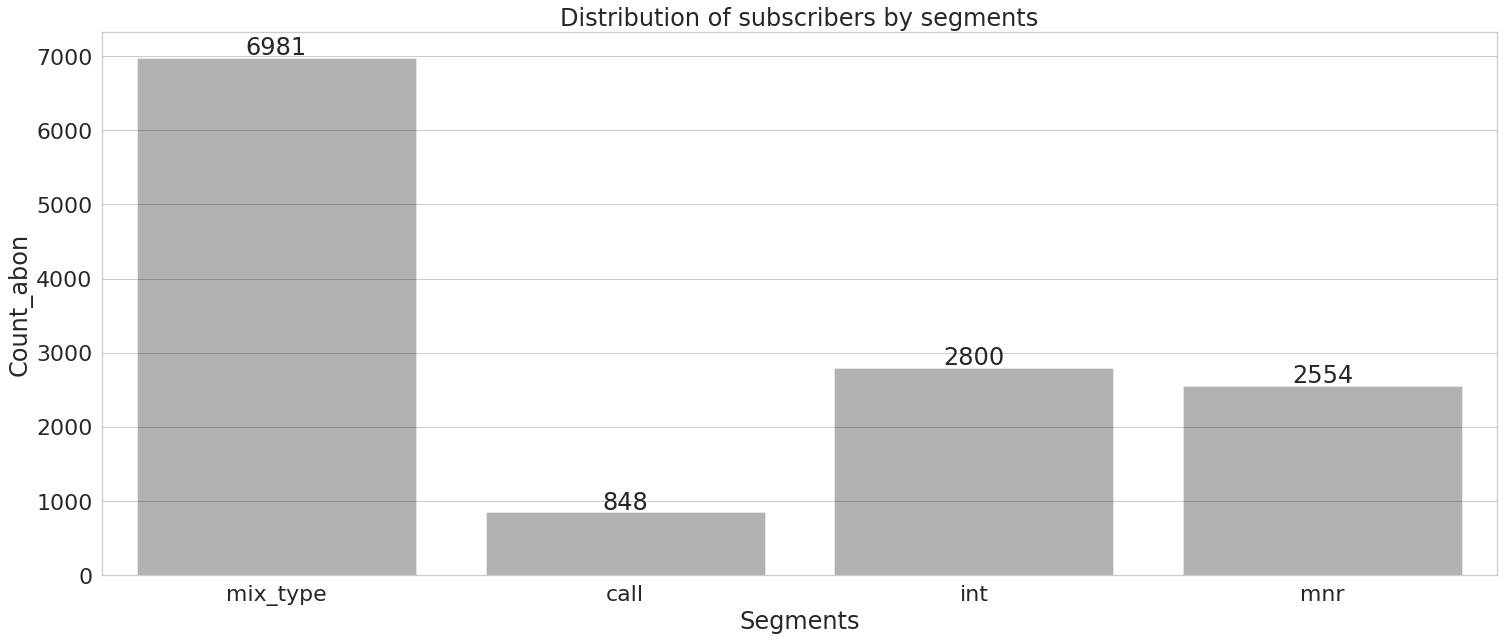

In [318]:
import matplotlib.pyplot as plt
import seaborn as sns

# Создаем countplot
ax = sns.countplot(data=df, x="key_type", color='black', alpha=0.3)

# Устанавливаем подписи осей
ax.set_ylabel('Count_abon')
ax.set_xlabel('Segments')
ax.set_title('Distribution of subscribers by segments')

# Добавляем числовые подписи к каждому столбику
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

plt.show()


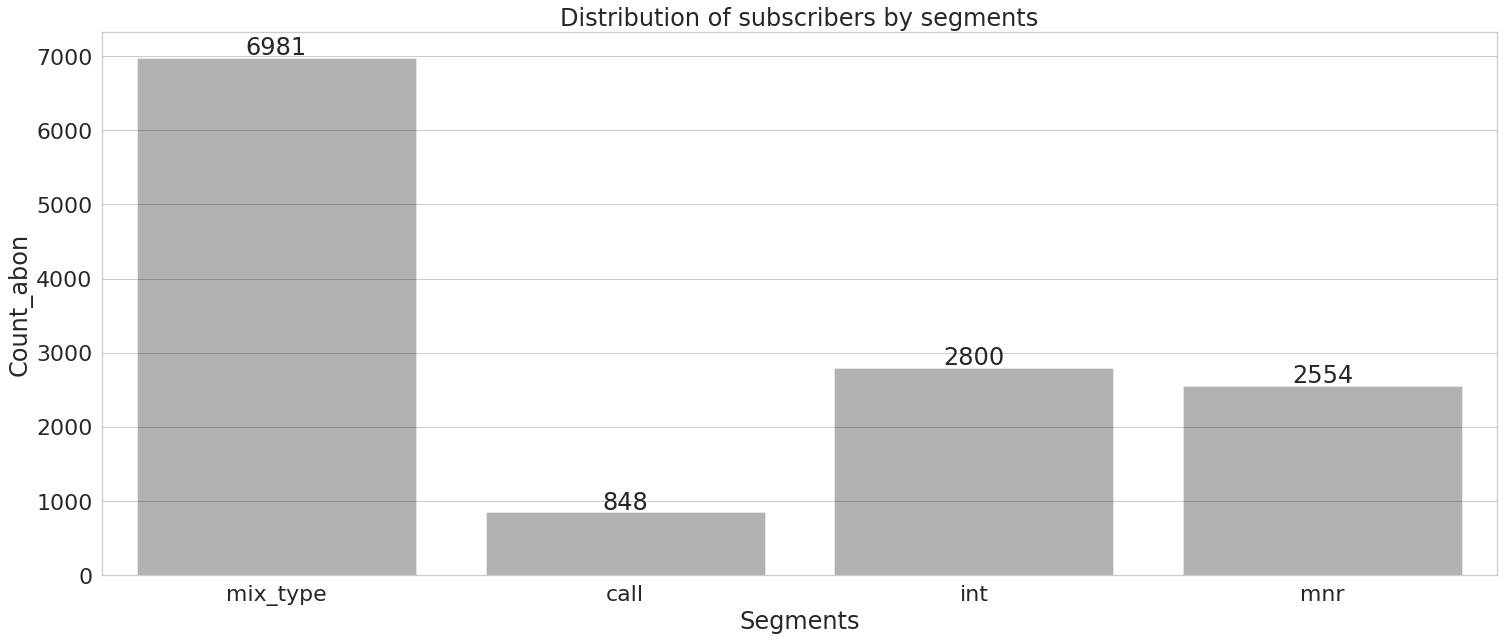

In [319]:
sns.set(
font_scale=2,
style="whitegrid",
rc={'figure.figsize':(25,10)}
        )

ax = sns.countplot(data=df, x="key_type", color='black', alpha=0.3)
plt.ylabel('Count_abon')
plt.xlabel('Segments')
plt.title('Distribution of subscribers by segments')
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

plt.show()

In [320]:
# считаю сумму начислений и средние начисления на абонента в каждом сегменте
agg_df = df.groupby('key_type').agg({'sum_r': ['sum', 'mean']}).reset_index()
agg_df.columns = ['key_type', 'sum', 'mean']
agg_df

,key_type,sum,mean
0,call,6083636,7174.099057
1,int,1503038432,536799.440000
2,mix_type,33663707,4822.189801
3,mnr,4509579,1765.692639


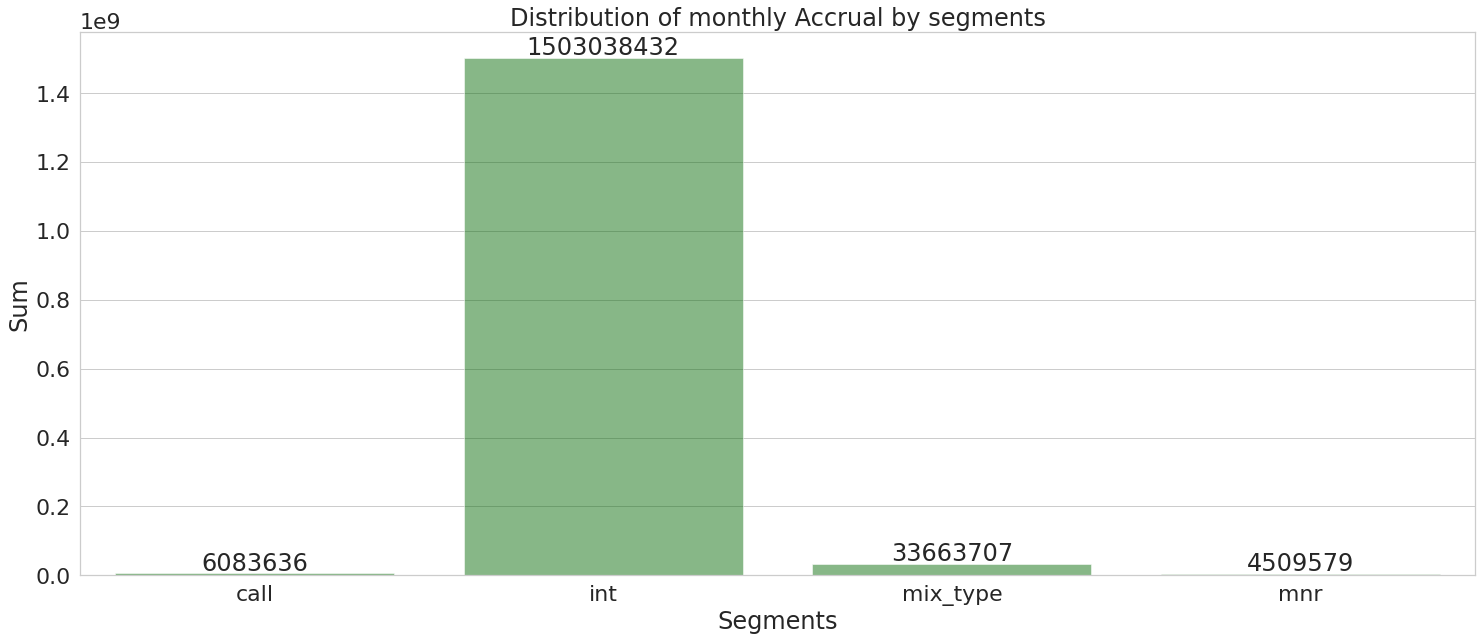

In [321]:
ax = sns.barplot(x='key_type', y='sum', data=agg_df, color='green', alpha=0.5)
plt.ylabel('Sum')
plt.xlabel('Segments')
plt.title('Distribution of monthly Accrual by segments')
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

plt.show()

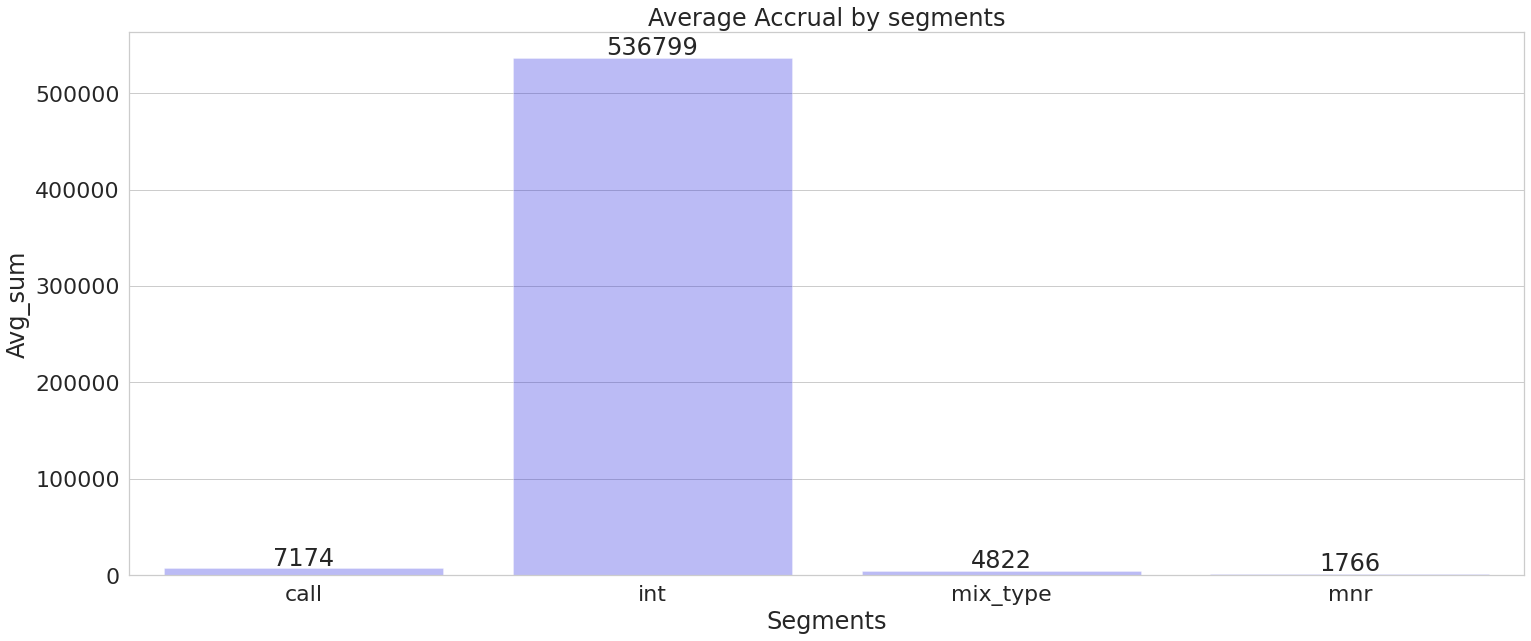

In [322]:
ax = sns.barplot(x='key_type', y='mean', data=agg_df, color='blue', alpha=0.3)
plt.ylabel('Avg_sum')
plt.xlabel('Segments')
plt.title('Average Accrual by segments')
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

plt.show()

Получается, что по реализованной сегментации самый многочисленный кластер с абонентами, использующими несколько видов трифика.
<br>А кластер с высокими начислениями с абонентами, которые генерируют интернет-трафик. Возможно такой перевес, т.к. я не ставила лимитов на интерент-трафик при исследовании.
<br>Также не огранимчивала 0 суммы, но здесь и суммарно без усреднения интернет-сегмент выше по начислениям.